In [1]:
# Importings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
import torch

In [2]:
# set random seed for reproducibility
import random  
import os
def set_all_seeds(seed=1):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_all_seeds(1)

In [3]:
# load data
df = pd.read_csv('ecg.csv', header=None)
raw_data = df.values
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [4]:
# split sets
labels = raw_data[:, -1]
features = raw_data[:, :-1]
X, test_X, y, test_y = train_test_split(
    features, labels, test_size=0.2, random_state=2
)
train_X, valid_X, train_y, valid_y = train_test_split(
    X, y, test_size=0.2, random_state=2
)

In [5]:
# Normalization to [0, 1]
scaler = MinMaxScaler()
scaler.fit(train_X)
train_X = scaler.transform(train_X)
valid_X = scaler.transform(valid_X)
test_X = scaler.transform(test_X)

In [6]:
# train the autoencoders with only normal rhythms
train_y = train_y.astype(bool)
test_y = test_y.astype(bool)

normal_train_X = train_X[train_y]
anomalous_train_X = train_X[~train_y]

normal_test_X = test_X[test_y]
anomalous_test_X = test_X[~test_y]

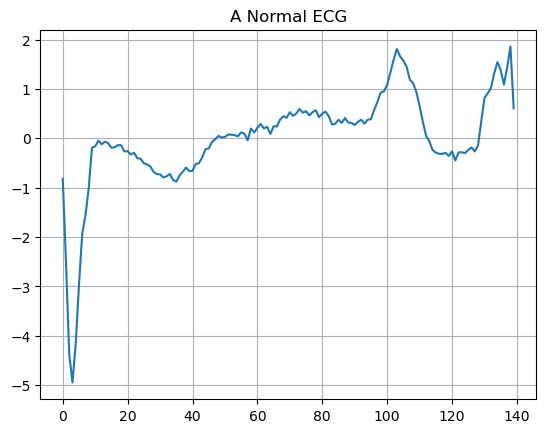

In [7]:
# plot a normal ECG

# denormalize the data for visualization 
original_train_normal = scaler.inverse_transform(normal_train_X)

plt.grid()
plt.plot(range(len(original_train_normal[1])), original_train_normal[1])
plt.title("A Normal ECG")
plt.show()


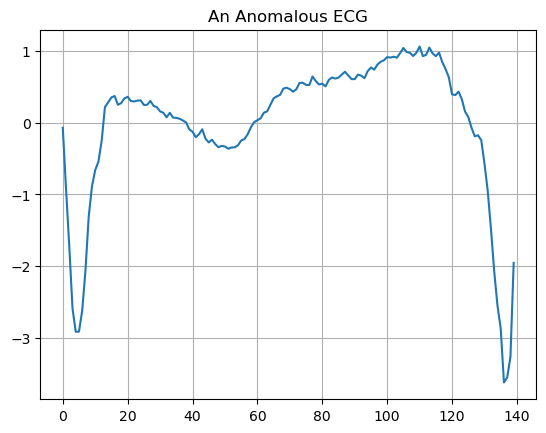

In [8]:
# Plot an anomalous ECG

# denormalize the data for visualization 
original_train_anomalous = scaler.inverse_transform(anomalous_train_X)

plt.grid()
plt.plot(range(len(original_train_anomalous[1])), original_train_anomalous[1])
plt.title("An Anomalous ECG")
plt.show()

In [9]:
# convert to pyTorch tensors
batch_size = 512
from torch.utils.data import DataLoader, TensorDataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_tensor = torch.FloatTensor(normal_train_X).to(device)
valid_tensor = torch.FloatTensor(valid_X).to(device)
train_dataset = TensorDataset(train_tensor, train_tensor)
valid_dataset = TensorDataset(valid_tensor, valid_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [10]:
# define the model
import torch.nn as nn
class AnomalyDetector(nn.Module):
    def __init__(self, input_dim=140):
        super(AnomalyDetector, self).__init__()
        # define the encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )

        # define the decoder
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Sigmoid()  # to ensure output is in [0, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

# instantiate the model
model = AnomalyDetector(input_dim=normal_train_X.shape[1]).to(device)

In [11]:
# define the loss function and optimizer
import torch.optim as optim
optimizer = optim.Adam(model.parameters())
criterion = nn.L1Loss()

In [12]:
# train the model
epochs = 20
train_losses = []
valid_losses = []
for epoch in range(epochs):
    # training phase
    model.train()
    train_loss = 0.0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        reconstructed = model(data)
        loss = criterion(reconstructed, data)
        
        loss.backward()
        optimizer.step()

        batch_size = data.size(0)
        train_loss += loss.item() * batch_size
        

    
    avg_train_loss = train_loss / len(train_loader.dataset)
    
    # validation phase
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for data, _ in valid_loader:
            reconstructed = model(data)
            loss = criterion(reconstructed, data)

            batch_size = data.size(0)
            val_loss += loss.item() * batch_size
    
    avg_val_loss = val_loss / len(valid_loader.dataset)
    
    # record losses
    train_losses.append(avg_train_loss)
    valid_losses.append(avg_val_loss)
    
    # print progress
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')



Epoch [1/20], Train Loss: 0.142864, Val Loss: 0.141707
Epoch [2/20], Train Loss: 0.139205, Val Loss: 0.138903
Epoch [3/20], Train Loss: 0.135910, Val Loss: 0.136340
Epoch [4/20], Train Loss: 0.132718, Val Loss: 0.133520
Epoch [5/20], Train Loss: 0.128925, Val Loss: 0.130054
Epoch [6/20], Train Loss: 0.124111, Val Loss: 0.125694
Epoch [7/20], Train Loss: 0.118082, Val Loss: 0.120427
Epoch [8/20], Train Loss: 0.110510, Val Loss: 0.114047
Epoch [9/20], Train Loss: 0.101298, Val Loss: 0.107001
Epoch [10/20], Train Loss: 0.091141, Val Loss: 0.101217
Epoch [11/20], Train Loss: 0.082766, Val Loss: 0.098557
Epoch [12/20], Train Loss: 0.076754, Val Loss: 0.094867
Epoch [13/20], Train Loss: 0.070086, Val Loss: 0.090003
Epoch [14/20], Train Loss: 0.064130, Val Loss: 0.086772
Epoch [15/20], Train Loss: 0.059996, Val Loss: 0.085049
Epoch [16/20], Train Loss: 0.056657, Val Loss: 0.084410
Epoch [17/20], Train Loss: 0.054375, Val Loss: 0.083632
Epoch [18/20], Train Loss: 0.052773, Val Loss: 0.082169
E

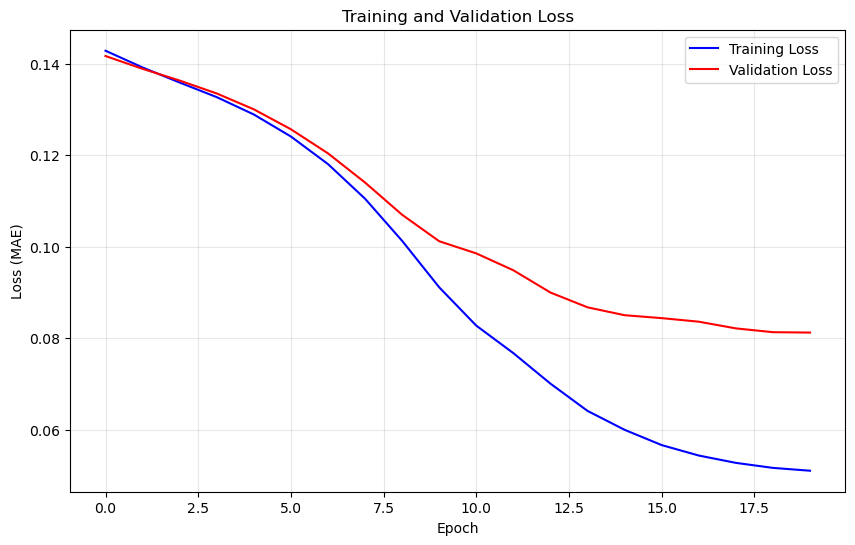

Final Training Loss: 0.051057
Final Validation Loss: 0.081256


In [13]:
# plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss", color='blue')
plt.plot(valid_losses, label="Validation Loss", color='red')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MAE)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final Training Loss: {train_losses[-1]:.6f}")
print(f"Final Validation Loss: {valid_losses[-1]:.6f}")

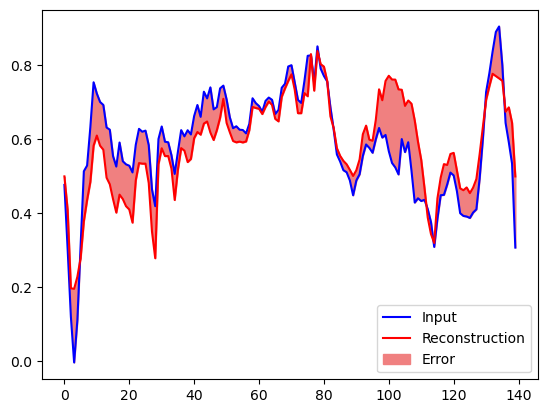

In [14]:
# Plotting reconstruction of normal data from test set
model.eval()
normal_test_X_tensor = torch.FloatTensor(normal_test_X).to(device)
with torch.no_grad():
    normal_decoded_data = model(normal_test_X_tensor).cpu().numpy()

plt.plot(normal_test_X[0], 'b')
plt.plot(normal_decoded_data[0], 'r')
plt.fill_between(np.arange(140), normal_decoded_data[0], normal_test_X[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

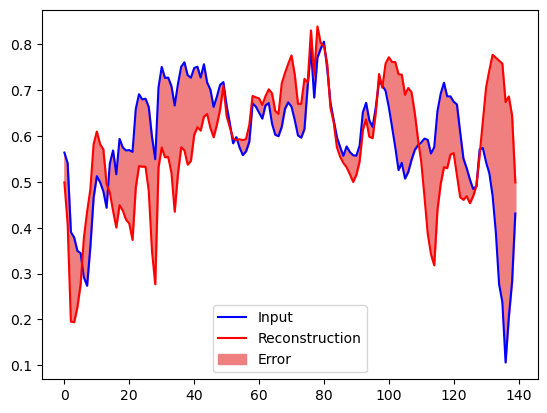

In [15]:
# Plotting reconstruction of anomalous data from the test set
model.eval()
anomalous_test_X_tensor = torch.FloatTensor(anomalous_test_X).to(device)
with torch.no_grad():
    anomalous_decoded_data = model(anomalous_test_X_tensor).cpu().numpy()

plt.plot(anomalous_test_X[0], 'b')
plt.plot(anomalous_decoded_data[0], 'r')
plt.fill_between(np.arange(140), anomalous_decoded_data[0], anomalous_test_X[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

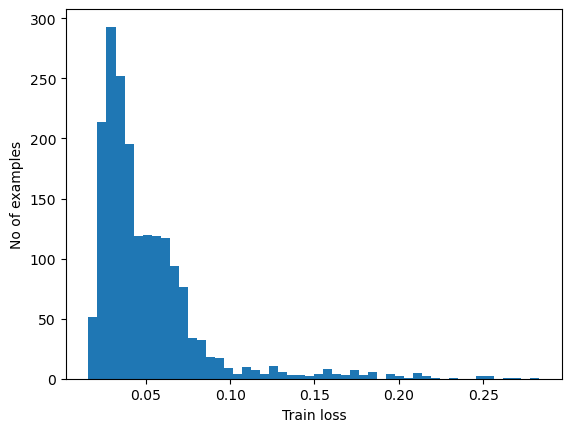

In [21]:
# detect anomalies
model.eval()
with torch.no_grad():
    reconstructions = model(train_tensor)
    train_loss = torch.mean(torch.abs(reconstructions - train_tensor), dim=1).cpu().numpy()
plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()
 

In [22]:
# determining threshold
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.084174216


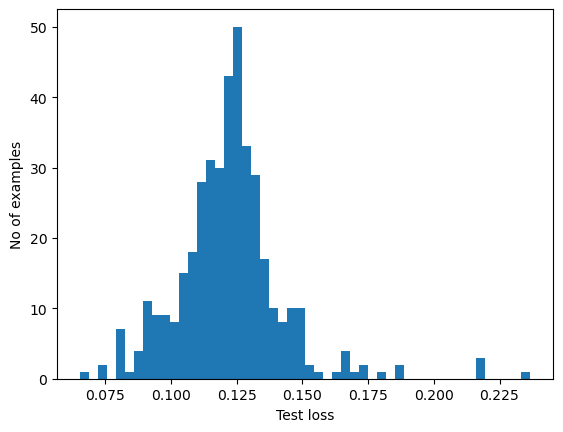

In [24]:
# check anomalies reconstrution distribution on test set
test_tensor = torch.FloatTensor(anomalous_test_X).to(device)
model.eval()
with torch.no_grad():
    reconstructions = model(test_tensor)
    test_loss = torch.mean(torch.abs(reconstructions - test_tensor), dim=1).cpu().numpy()

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [29]:
# prediction and evaluation
from sklearn.metrics import roc_curve
import torch.nn.functional as F
def predict(model, data, threshold):
  model.eval()
  data_tensor = torch.FloatTensor(test_X).to(device)
  with torch.no_grad():
    reconstructions = model(data_tensor)
    test_loss = torch.mean(torch.abs(reconstructions - data_tensor), dim=1).cpu().numpy()
  prediction = (test_loss < threshold).astype(int)
  return prediction



prediction = predict(model, test_X, threshold)

fpr, tpr, _ = roc_curve(prediction, test_y)
print("TPR: {}, FPR: {}".format(tpr[1], fpr[1]))

TPR: 0.9803220035778175, FPR: 0.11337868480725624
